## The Mindlin plate problem

This tutorial aims at illustrating the use of the Partitioned Finite Element Method (PFEM) (Cardoso-Ribeiro et al, 2018) to discretize a port-Hamiltonian system (pHs) related to isotropic Mindlin plate under mixed boundary conditions (i.e. Dirichlet or Neumann boundary conditions). We specifically show how to define and solve this problem inside Scrimp. 

We first define the continuous problem. Then we tackle the semi-discretization in space of the port-Hamiltonian system through the PFEM methodology. This discretization leads to a pHDAE formulation. After time discretization, we perform a numerical simulation to obtain an approximation of the space-time solution. Finally a simple postprocessing is performed. 

In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import set_matplotlib_formats

# plt.rcParams['figure.autolayout'] = False
# plt.rcParams['figure.figsize'] = 10, 6
# plt.rcParams['axes.labelsize'] = 18
# plt.rcParams['axes.titlesize'] = 20
# plt.rcParams['font.size'] = 16
# plt.rcParams['lines.linewidth'] = 2.0
# plt.rcParams['lines.markersize'] = 8
# plt.rcParams['legend.fontsize'] = 14

from matplotlib import rcParams

SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)  # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)  # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)  # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

rcParams.update({'figure.autolayout': False})
rcParams['text.usetex'] = True

import numpy as np
import Scrimp
from math import pi

/usr/local/lib/python3.8/dist-packages/Assimulo-trunk-py3.8-linux-x86_64.egg/assimulo/solvers/odepack.py:710: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  N.array([[0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.],  # 5th order
Could not find GLIMDA.


## Problem statement


We consider the Mindin plate problem defined for all $t\ge 0$ as

\begin{equation}
\begin{aligned}
   \displaystyle \rho b \partial_{tt} w &= \mathrm{div}(\boldsymbol{q}), \quad \boldsymbol x \in \Omega = \{0, L_x\}\times \{0, L_y\},  \\
\displaystyle \frac{\rho b^3}{12} \partial_{tt}{\boldsymbol \theta} &= \boldsymbol{q} + \mathrm{Div}(\boldsymbol{M}) \\
\end{aligned}
\end{equation}

with initial conditions

\begin{equation}
\begin{aligned}
    w(0, \boldsymbol x) &= 0, \\
    {\partial_t} w(0,\boldsymbol x) &= w_1(x),  \\
\end{aligned} \qquad
\begin{aligned}
   \boldsymbol{\theta}(0, \boldsymbol x) & = \boldsymbol{0}, \\
  {\partial_t} \boldsymbol{\theta}(0,\boldsymbol x) &= \boldsymbol{0}, \\
\end{aligned} \qquad
\begin{aligned}
\boldsymbol x &\in \Omega, t=0,\\
\boldsymbol x &\in \Omega, t=0,\\
\end{aligned}
  \end{equation}
  
and boundary conditions
\begin{equation}
\begin{aligned}
    w\vert_{\Gamma_D}&=f(t), \\
    \boldsymbol{q} \cdot \boldsymbol{n}\vert_{\Gamma_N}&=g(t), \\
\end{aligned} \qquad
\begin{aligned}
    \boldsymbol{\theta}\vert_{\Gamma_D}&=0,  \\ 
     \quad \boldsymbol{M} \cdot \boldsymbol{n}\vert_{\Gamma_N}&=0,  \\ 
\end{aligned} \qquad
\begin{aligned}
\boldsymbol x \in \Gamma_D&=\{x=0 \}, \\
\boldsymbol x \in \Gamma_N&=\{x=L_x, y=0, y=L_y\},
\end{aligned}
\end{equation}

where $\rho$ is the mass density, $b$ the plate thickness, $w$ the vertical displacement, $\boldsymbol \theta = (\theta_x, \theta_y)^\top$ collects the deflection of the cross section along axes $x$ and $y$ respectively. The fields $f, \boldsymbol{\tau}$ represent distributed forces and torques. Variables $\boldsymbol{M}, \boldsymbol{q}$ represent the momenta tensor and the shear stress. Hooke's law relates those to the curvature tensor and shear deformation vector

\begin{equation*}
\begin{aligned}
\boldsymbol{M} &:= \boldsymbol{\mathcal{D}}_b \boldsymbol{K} \in \mathbb{S}, \\ \boldsymbol{q} &:= {D}_s \boldsymbol{\gamma},
\end{aligned} \qquad
\begin{aligned}
\boldsymbol{K} &:= \mathrm{Grad}(\boldsymbol{\theta}) \in \mathbb{S}, \\ \boldsymbol{\gamma} &:= \mathrm{grad}(w) - \boldsymbol{\theta}.
\end{aligned}
\end{equation*}

${D}_s:=\frac{E b k }{2(1+\nu)}$ is the shear rigidity coefficient. Tensor $\boldsymbol{\mathcal{D}}_b$ is the bending stiffness 
\begin{equation}
\label{eq:bend_rig_tensor}
\boldsymbol{\mathcal{D}}_b (\cdot) = \frac{E_Y b^3}{12 (1 - \nu^2)}\{(1-\nu)(\cdot) + \nu \mathrm{Tr}(\cdot)\},
\end{equation}

where $E_Y$ is the Young modulus, $\nu$ is the Poisson modulus, $k$ is the shear correction factor.
 The Hamiltonian $H$ (total energy) read
 
\begin{equation}
H =  \frac{1}{2} \int_{\Omega} \left\{ \rho b \left(\partial_t{w} \right)^2 +  \frac{\rho b^3}{12} \vert\vert\partial_t\boldsymbol{\theta}\vert\vert^2  + \boldsymbol{K} \cdot (\boldsymbol{\mathcal{D}}_b \boldsymbol{K}) + D_s \vert\vert\boldsymbol{\gamma}\vert\vert^2\right\} d\Omega,
\end{equation} 

Mixed boundary conditions are considered in this example. The subsets $\Gamma_N, \; \Gamma_D$ represent the subsets of the boundary where Neumann and Dirichlet like conditions hold respectively. The Dirichlet conditions are enforced using Lagrange multipliers.

## Port-Hamiltonian formulation 

An appropriate selection of the energy variables is the following 
\begin{equation}
\alpha_w=  \rho b\partial_{t} w,  \qquad
\boldsymbol{\alpha}_{\theta} := \frac{\rho b^3}{12}\partial_{t} \boldsymbol{\theta}, \qquad
\boldsymbol{A}_{\kappa} := \boldsymbol{K}, \qquad
\boldsymbol{e}_{\gamma} := \boldsymbol{\gamma}. 
\end{equation}

The co-energy variables are defined as follows

\begin{equation}
e_w := \delta_{\alpha_w} H = \partial_{t} w,  \qquad
\boldsymbol{e}_{\theta} := \delta_{\boldsymbol\alpha_\theta} H =\partial_{t} \boldsymbol{\theta}, \qquad
\boldsymbol{E}_{\kappa} := \delta_{\boldsymbol{A}_\kappa} H =\boldsymbol{M}, \qquad
\boldsymbol{e}_{\gamma} := \delta_{\boldsymbol\alpha_\gamma} H =\boldsymbol{q}. 
\end{equation}

Its port-Hamiltonian formulation is given by the following linear hyperbolic system (see <a href="https://www.sciencedirect.com/science/article/abs/pii/S0307904X19302331">"Port-Hamiltonian formulation and symplectic discretization of plate models. Part {I}: Mindlin model for thick plates"</a> by Brugnoli et al, 2019) in co-energy variables (the forces and torques have been omitted for simplicity)

\begin{align*}
\begin{bmatrix}
\rho b  & 0  & 0  & 0 \\
\boldsymbol{0} & \frac{\rho b^3}{12} &  \boldsymbol{0} & \boldsymbol{0}\\
\boldsymbol{0}  & \boldsymbol{0}  & \boldsymbol{\mathcal{D}}_b^{-1}  & \boldsymbol{0}\\
\boldsymbol{0} & \boldsymbol{0} &  \boldsymbol{0} & D_s^{-1} \\
\end{bmatrix}
\frac{\partial}{\partial t}
\begin{pmatrix}
e_w \\
\boldsymbol{e}_{\theta} \\
\boldsymbol{E}_{\kappa}\\
\boldsymbol{e}_{\gamma}
\end{pmatrix} &= 
\begin{bmatrix}
	0  & 0  & 0  & \mathrm{div} \\
	\boldsymbol{0} & \boldsymbol{0} &  \mathrm{Div} & \boldsymbol{I}_{2 \times 2}\\
	\boldsymbol{0}  & \mathrm{Grad}  & \boldsymbol{0}  & \boldsymbol{0}\\
	\mathrm{grad} & -\boldsymbol{I}_{2 \times 2} &  \boldsymbol{0} & \boldsymbol{0} \\
	\end{bmatrix}
\begin{pmatrix}
e_w \\
\boldsymbol{e}_{\theta} \\
\boldsymbol{E}_{\kappa} \\
\boldsymbol{e}_{\gamma} \\
\end{pmatrix},  \label{eq:pHdyn_Min1}  \\
\boldsymbol{u}_\partial 
&=
\begin{bmatrix}
	{0} &  {0} & {0} & \gamma_{\perp}^{\Gamma_N} \\
	{0} &  {0} & \boldsymbol\gamma_{\perp}^{\Gamma_N} & {0} \\
	\gamma_{0}^{\Gamma_D} & {0} & {0} & {0} \\
	{0} & \boldsymbol\gamma_{0}^{\Gamma_D} & {0} & {0} \\
	\end{bmatrix}
\begin{pmatrix}
e_w \\
\boldsymbol{e}_{\theta} \\
\boldsymbol{E}_{\kappa} \\
\boldsymbol{e}_{\gamma} \\
\end{pmatrix}, \\
\boldsymbol{y}_\partial &=
	\begin{bmatrix}
	{0} &  {0} & {0} & \gamma_{\perp}^{\Gamma_D} \\
	{0} &  {0} & \boldsymbol\gamma_{\perp}^{\Gamma_D} & {0} \\
	\gamma_{0}^{\Gamma_N} & {0} & {0} & {0} \\
	{0} & \boldsymbol\gamma_{0}^{\Gamma_N} & {0} & {0} \\
	\end{bmatrix}
\begin{pmatrix}
e_w \\
\boldsymbol{e}_{\theta} \\
\boldsymbol{E}_{\kappa} \\
\boldsymbol{e}_{\gamma} \\
\end{pmatrix}. 
\end{align*}


## Setup

We initialize here the Python object related to the Mindlin class of Scrimp. This object will be used throughout this 
tutorial. 

In [2]:
Min = Scrimp.Mindlin()

### Constants

We define the constants related to the definition of the rectangular domain $\Omega$. The coordinates of the left bottom $(x_0, y_0) =(0, 0)$ and the right top $(x_L, y_L) = (L_x, L_y)$ corners of the rectangle are required. 

In [3]:
x0, xL, y0, yL = 0., 2., 0., 1.

We then define the time interval related to the time discretization. $t_i, t_f$ denote the initial and final time instants respectively. 

In [4]:
ti, tf  = 0., 0.01

We specify that we choose a Runge-Kutta method for the time integration of the system (once it is converted to a purely differential system). This method is conditionally stable, so the time-step has to be set accurately to avoid numerical instabilities.

In [5]:
dt           = 1.e-6
dae_library  = 'DAE:RK4_Augmented'

### FEniCS expressions definition

For the finite element discretization of the spatial port-Hamiltonian formulation, the FEniCS library is used in the Mindlin class of Scrimp. The coefficients for the physical parameters of the isotropic plate can be provided as either real numbers or FEniCS expressions. 

In [6]:
E   = 7*10**10
rho = 2700
nu  = 0.3
h   = 0.1
k   = 5/6

Similarly we can specify as a string the initial vertical condition $w_1$. This string represents a C++ code that will be compiled by the Dolfin library of FEniCS.

In [7]:
ew_0 = 'x[0]*x[1]'

This means that the initial velocity satisfies $w_1= xy$. Notice that the initial condition must respect the boundary conditions. The other initial conditions will be set to zero.

## Problem at the continuous level

We are now able to completely define the problem at the continuous level. We start by specifying that the computational domain $\Omega$ is of rectangular shape. To define $\Omega$, we provide the coordinates of the bottom left and up right corners to the Mindlin object.

In [8]:
Min.Set_Rectangular_Domain(x0, xL, y0, yL);

We provide the time integration interval. 

In [9]:
Min.Set_Initial_Final_Time(ti, tf);

We then provide the physical parameters related to the Mindlin plate: the mass density $\rho$, the thickness $h$ the Young's modulus $E$, the Poisson ratio $\nu$ and the shear correction factor $k$, respectively.

In [10]:
Min.Set_Physical_Parameters(rho, h, E, nu, k, init_by_value=True);

We set the initial conditions in terms of co-energy variables. 

In [11]:
Min.Set_Initial_Data(W_0='0', Th1_0='0', Th2_0='0',\
                     ew_0=ew_0, eth1_0='0', eth2_0='0',\
                     Ekap11_0='0', Ekap12_0='0', Ekap22_0='0',\
                     egam1_0='0', egam2_0='0');

## Problem at the discrete level in space and time

We use the Partitioned Finite Element Method to obtain the semi-discretization in space of the port-Hamiltonian system. The structure preserving discretization of the open-loop infinite-dimensional port-Hamiltonian system with the PFEM method is described in detail. Formally we obtain a pHs of the following type

\begin{equation}
\begin{aligned}
\begin{bmatrix}
\mathbf{M}_{\rho b} & \mathbf{0} & \mathbf{0} & \mathbf{0} \\
\mathbf{0} & \mathbf{M}_{\rho b^3} & \mathbf{0} & \mathbf{0} \\
\mathbf{0} & \mathbf{0} & \mathbf{M}_{\boldsymbol{\mathcal{D}}_b^{-1}} & \mathbf{0} \\
\mathbf{0} & \mathbf{0} & \mathbf{0} & \mathbf{M}_{{D}_s^{-1}} \\
\end{bmatrix}
\begin{pmatrix}
\dot{\mathbf{e}}_{w} \\
\dot{\mathbf{e}}_{\theta} \\
\dot{\mathbf{e}}_{\kappa} \\
\dot{\mathbf{e}}_{\gamma} \\
\end{pmatrix}
&= \begin{bmatrix}
\mathbf{0} & \mathbf{0} & \mathbf{0} & -\mathbf{D}_{\mathrm{grad}}^\top \\
\mathbf{0} & \mathbf{0} & -\mathbf{D}_{\mathrm{Grad}}^\top & -\mathbf{D}_{0}^\top \\
\mathbf{0} & \mathbf{D}_{\mathrm{Grad}} & \mathbf{0} & \mathbf{0}\\
\mathbf{D}_{\mathrm{grad}} & \mathbf{D}_{0} & \mathbf{0} & \mathbf{0}\\
\end{bmatrix} 
\begin{pmatrix}
{\mathbf{e}}_{w} \\
{\mathbf{e}}_{\theta} \\
{\mathbf{e}}_{\kappa} \\
{\mathbf{e}}_{\gamma} \\
\end{pmatrix} + 
\begin{bmatrix}
\mathbf{B}_w & \mathbf{0}  & \mathbf{0} \\
\mathbf{0} & \mathbf{B}_{\theta_n} & \mathbf{B}_{\theta_s}\\
\mathbf{0} & \mathbf{0}  & \mathbf{0}\\
\mathbf{0} & \mathbf{0}  & \mathbf{0}\\
\end{bmatrix}
\begin{pmatrix}
\mathbf{u}_{\partial, 1} \\
\mathbf{u}_{\partial, 2} \\
\mathbf{u}_{\partial, 3} \\
\end{pmatrix},
\\
\begin{bmatrix}
\mathbf{M}_{\partial, 1} & \mathbf{0} & \mathbf{0} \\
\mathbf{0} &  \mathbf{M}_{\partial, 2} & \mathbf{0} \\
\mathbf{0} & \mathbf{0} &  \mathbf{M}_{\partial, 3} \\
\end{bmatrix}{}
\begin{pmatrix}
\mathbf{y}_{\partial, 1} \\
\mathbf{y}_{\partial, 2} \\
\mathbf{y}_{\partial, 3} \\
\end{pmatrix} &= \begin{bmatrix}
\mathbf{B}_w^\top & \mathbf{0} & \mathbf{0} & \mathbf{0} \\
\mathbf{0} & \mathbf{B}_{\theta_n}^\top & \mathbf{0} & \mathbf{0}\\ 
\mathbf{0} & \mathbf{B}_{\theta_s}^\top & \mathbf{0} & \mathbf{0}\\ 
\end{bmatrix}
\begin{pmatrix}
{\mathbf{e}}_{w} \\
{\mathbf{e}}_{\theta} \\
{\mathbf{e}}_{\kappa} \\
{\mathbf{e}}_{\gamma} \\
\end{pmatrix}.
\end{aligned}
\end{equation}

where $\mathbf{u}_{\partial, 1}, \mathbf{u}_{\partial, 2}, \mathbf{u}_{\partial, 3}$ are the dofs associated to $\boldsymbol{q} \cdot \boldsymbol{n}\vert_{\partial\Omega}, \;  \boldsymbol{n}^\top\boldsymbol{M}\boldsymbol{n}\vert_{\partial\Omega}, \; \boldsymbol{s}^\top\boldsymbol{M}\boldsymbol{n}\vert_{\partial\Omega}$ respectively. This system can be rewritten compactly as

\begin{equation}
\begin{aligned}
\begin{bmatrix}
\mathbf{M}_{p} & \mathbf{0} \\
\mathbf{0} & \mathbf{M}_{q} \\
\end{bmatrix}
\begin{pmatrix}
\dot{\mathbf{e}}_{p} \\
\dot{\mathbf{e}}_{q} \\
\end{pmatrix}
&= \begin{bmatrix}
\mathbf{0} & -\mathbf{D}^\top \\
\mathbf{D} & \mathbf{0}\\
\end{bmatrix} 
\begin{pmatrix}
{\mathbf{e}}_{p} \\
{\mathbf{e}}_{q} \\
\end{pmatrix} + 
\begin{bmatrix}
\mathbf{B}_p  \\
\mathbf{0}  \\
\end{bmatrix}
\mathbf{u}_{\partial},
\\
\mathbf{M}_{\partial} 
\mathbf{y}_{\partial}  &= \begin{bmatrix}
\mathbf{B}_p^\top & \mathbf{0} \\ 
\end{bmatrix}
\begin{pmatrix}
{\mathbf{e}}_{p} \\
{\mathbf{e}}_{q} \\
\end{pmatrix}.
\end{aligned}
\end{equation}

In the case of mixed boundary conditions a Lagrange multiplier is introduced to enforce weakly the Dirichlet condition

\begin{equation}
\begin{aligned}
\begin{bmatrix}
\mathbf{M}_{p} & \mathbf{0} & \mathbf{0} \\
\mathbf{0} & \mathbf{M}_{q} & \mathbf{0} \\
\mathbf{0} & \mathbf{0} & \mathbf{0} \\
\end{bmatrix}
\begin{pmatrix}
\dot{\mathbf{e}}_{p} \\
\dot{\mathbf{e}}_{q} \\
\dot{\boldsymbol{\lambda}}
\end{pmatrix}
&= \begin{bmatrix}
\mathbf{0} & -\mathbf{D}^\top & \mathbf{B}_p^{\Gamma_D}\\
\mathbf{D} & \mathbf{0} & \mathbf{0}\\
\mathbf{B}_p^{\Gamma_D \top} & \mathbf{0} & \mathbf{0}\\
\end{bmatrix} 
\begin{pmatrix}
{\mathbf{e}}_{p} \\
{\mathbf{e}}_{q} \\
\boldsymbol{\lambda}
\end{pmatrix} + 
\begin{bmatrix}
\mathbf{B}_p^{\Gamma_N} & \mathbf{0} \\
\mathbf{0} & \mathbf{0} \\
\mathbf{0} & \mathbf{M}_{\partial}^{\Gamma_D}
\end{bmatrix}
\begin{pmatrix}
\mathbf{u}_{\partial}^{\Gamma_N} \\
\mathbf{u}_{\partial}^{\Gamma_D} \\
\end{pmatrix},
\\
\begin{bmatrix}
\mathbf{M}_{\partial}^{\Gamma_N} & \mathbf{0} \\
\mathbf{0} & \mathbf{M}_{\partial}^{\Gamma_D}
\end{bmatrix}
\begin{pmatrix}
\mathbf{y}_{\partial}^{\Gamma_N} \\
\mathbf{y}_{\partial}^{\Gamma_D} \\
\end{pmatrix}
 &= \begin{bmatrix}
\mathbf{B}_p^{\Gamma_N \top} & \mathbf{0} & \mathbf{0} \\ 
\mathbf{0} & \mathbf{0} & \mathbf{M}_{\partial}^{\Gamma_D} \\
\end{bmatrix}
\begin{pmatrix}
{\mathbf{e}}_{p} \\
{\mathbf{e}}_{q} \\
\boldsymbol{\lambda} \\
\end{pmatrix}.
\end{aligned}
\end{equation}

where $\mathbf{u}_{\partial}^{\Gamma_N}$ are the dofs associated to $\boldsymbol{q} \cdot \boldsymbol{n}\vert_{\Gamma_N}, \;  \boldsymbol{n}^\top\boldsymbol{M}\boldsymbol{n}\vert_{\Gamma_N}, \; \boldsymbol{s}^\top\boldsymbol{M}\boldsymbol{n}\vert_{\Gamma_N}$ respectively, and $\mathbf{u}_{\partial}^{\Gamma_D}$ are the dofs associated to $\partial_t w\vert_{\Gamma_D}, \;  \partial_t \boldsymbol{\theta} \cdot \boldsymbol{n}\vert_{\Gamma_D}, \; \partial_t \boldsymbol{\theta} \cdot \boldsymbol{s}\vert_{\Gamma_D}$ respectively.

We start by selecting the computational mesh which is generated with Gmsh. The first parameter corresponds to a mesh refinement parameter.

In [12]:
Min.Generate_Mesh(10, structured_mesh=True);

----------------------------------------
Mesh: hmax= 0.2 Nv= 116
Mesh: OK
----------------------------------------


To perform the discretization in space, we must first specify the conforming finite element approximation spaces to be used. The finite element for the linear and angular velocity are Lagrange polynomials of order r. The momenta tensor and shear stress are chosen as Discontinous Galerkin elements of order r-1. By default, the boundary variables are approximated as Lagrange polynomials of order 1. This can be changed through the option 'family_b' for the family, and 'rb' for the degree.

In [13]:
Min.Set_Finite_Element_Spaces(r=1);

----------------------------------------
Npw= 116 ,	 Npth= 232 ,	 Nqth= 600 ,	 Nqw= 400 ,	 Nb= 30
DOFsys= 1348
FE spaces: OK
---------------------------------------- 



We then perform the semi-discretization in space of the weak formulation with the PFEM method. At the end of this stage, the complete formulation of the pHDAE is obtained. The different matrices related to the pHDAE system are constructed in the Assembly_Mixed_BC method of the Mindlin class of Scrimp and are directly accessible through the object of the Mindlin class. The finite element assembly relies on the variational formulation of PFEM and exploits the level of abstraction provided by the unified form language (UFL) used in FEniCS, leading to a code that is close to the mathematical formulation. The subsets G1, G2, G3, G4 denote the left, bottom, right and top side of the rectangle, respectively.

                     G4
                 —— —— —— ——
                |           | 
             G1 |           | G3
                |           |
                 —— —— —— —— 
                     G2 
                     
 
In Scrimp the boundary control is assumed to take the form 

\begin{equation}
\boldsymbol{u}_\partial = \mathrm{Ub\_tm0}(t) \times \mathrm{Ub\_sp0}(\boldsymbol{x}) + \mathrm{Ub\_tm1}(t) + Ub_sp1(\boldsymbol{x}).
\end{equation}

Its time derivative is simply expressed as 
\begin{equation}
\dot{\boldsymbol{u}}_\partial = \mathrm{Ub\_tm0\_dir}(t) \times \mathrm{Ub\_sp0}(\boldsymbol{x}) + \mathrm{Ub\_tm1\_dir}(t).
\end{equation}

To integrate in time the equation we need to provide the derivative of the boundary condition so to reduce the index of the differential algebraic system. This information is provided by the variables $\mathrm{Ub\_tm0\_dir}, \; \mathrm{Ub\_tm1\_dir}$.  

For the Neumann boundary condition consider 

\begin{equation}
g(t) = 10^5 \sin\left(\frac{2 \pi x}{x_L}\right)(1-\exp^{\displaystyle -10 \frac{t}{t_f}}).
\end{equation}

For the Dirichlet boundary condition we impose a sinusoidal movement

\begin{equation}
f(t) = A (\cos(\omega t) - 1),
\end{equation}
meaning that $e_w\vert_{\Gamma_D} = f'(t) = - A \omega \sin(\omega t)$. 

In [14]:
Min.Set_Mixed_Boundaries(Dir=['G1'], Nor=['G2', 'G3', 'G4'])
Min.Assembly_Mixed_BC() 
Min.Set_Mixed_BC_Normal(Ub_tm0=lambda t: np.array([(1 - np.exp(-t/tf) ),0,0]) ,\
                        Ub_sp0=('100000*sin(2*pi/xL*x[0])', '0.', '0.'))
amp   = 0.01
omega = 2*pi/tf
Min.Set_Mixed_BC_Dirichlet(Ub_tm0=lambda t : np.array([-amp*omega*np.sin(omega*t),0,0]), Ub_sp0=('1.', '0.','0.'),\
                           Ub_tm0_dir=lambda t : np.array([-amp*omega**2*np.cos(omega*t),0,0]));

----------------------------------------
Clamped condition: G1
Free condition: G2,  G3,  G4
Mixed Boundaries: OK
---------------------------------------- 

----------------------------------------
Nb_D= 6 ,	 Nb_N= 26
DOFsysDAE= 1354
DAE system: OK
---------------------------------------- 



To perform the time integration of the pHDAE, we first need to interpolate the initial data on the appropriate finite element spaces. 

In [15]:
Min.Project_Boundary_Control()
Min.Project_Initial_Data();

----------------------------------------
Project BC: OK
Project initial data: OK
----------------------------------------


Then we specify the parameters related to the time discretization. 

In [16]:
Min.Set_Time_Setting(dt);

We finally check that the space-time discrete problem has been completely defined. 

In [17]:
assert Min.Check_Space_Time_Discretization() == 1, "Space and time discretization to be checked again !"

## Numerical approximation of the space-time solution

For the numerical approximation of the solution of the pHDAE system, the algebraic condition is differentiated. This allows expressing the Lagrange multiplier as a function of the unknown and the derivative of the input (known as 'Decoupling  by  projection', see <a href="https://pure.mpg.de/rest/items/item_2225593/component/file_2251186/content">"Time-dependent Dirichlet conditions in finite element discretizations"</a> by Benner and Heiland, 2015). The resulting system is then a purely differential one. We integrate such system with a Runge-Kutta method. 

In [18]:
A, Hamiltonian = Min.Time_Integration(dae_library)

Time-stepping : |################################################## 100%|

Time integration completed !
---------------------------------------- 



## Post-processing

We represent the two-dimensional mesh with corresponding degrees of freedom for each variable. 

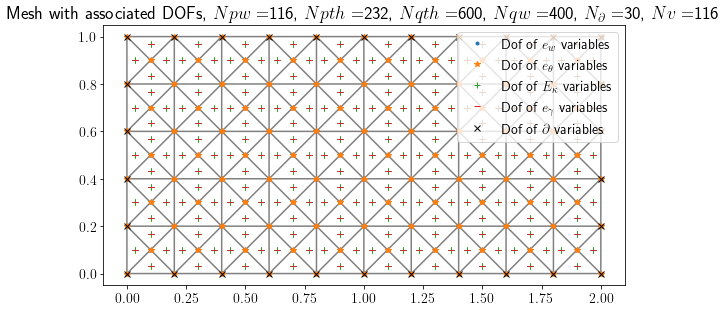

In [19]:
Min.notebook = True
Min.Plot_Mesh_with_DOFs()

We plot the Hamiltonian function versus time. 

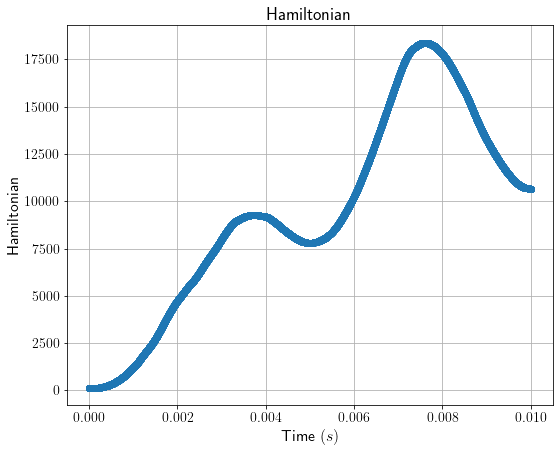

In [20]:
Min.Plot_Hamiltonian(Min.tspan,Hamiltonian, marker='o')

The behaviour of the deflection can be graphically represented at a given time. Here we simply plot the deflection at the final time. 

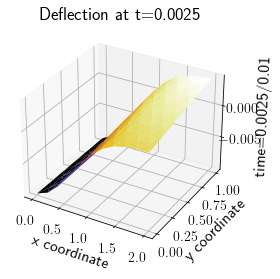

In [21]:
Min.Plot_3D(Min.Get_Deflection(A), tf/4, 'Deflection at t='+str(tf/4))

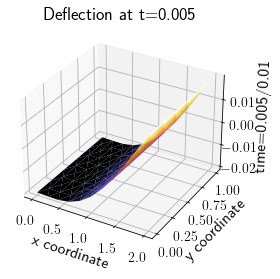

In [22]:
Min.Plot_3D(Min.Get_Deflection(A), tf/2, 'Deflection at t='+str(tf/2))

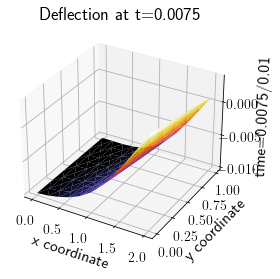

In [23]:
Min.Plot_3D(Min.Get_Deflection(A), 3*tf/4, 'Deflection at t='+str(3*tf/4))

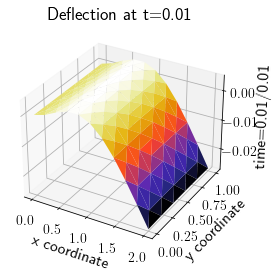

In [24]:
Min.Plot_3D(Min.Get_Deflection(A), tf, 'Deflection at t='+str(tf))

Furthermore the time evolution of the deflection can be obtained as an animation that can be saved as a movie file. 

In [21]:
movie = True
if movie:
    %matplotlib tk
    Min.Set_Video_Writer()
    Min.Moving_Trisurf(Min.Get_Deflection(A), step=50, title='Deflection versus time', save=False)
    %matplotlib inline

# Further information

- "A port-Hamiltonian formulation of flexible structures. Modelling and structure-preserving finite element discretization", A. Brugnoli, PhD thesis, University of Toulouse, ISAE-SUPAERO, France, 2020. 


- <a href="https://www.sciencedirect.com/science/article/pii/S2405896318303252">"Structure-preserving Partitioned Finite Element Method for the 2D wave equation"</a> by F. L. Cardoso-Ribeiro, D. Matignon, L. Lefèvre. In IFAC-PapersOnLine, 51 (3), 119–124, 2018.


- <a href="https://www.sciencedirect.com/science/article/abs/pii/S0307904X19302331">"Port-Hamiltonian formulation and symplectic discretization of plate models. Part {I}: Mindlin model for thick plates"</a> by A. Brugnoli, D. Alazard, V. Pommier-Budinger, D. Matignon. Applied Mathematical Modelling, 75, 940-960, 2019.
